In [1]:
%%writefile trajectories.py
import numpy as np
import gc
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import stats

mini_batch_size = 64
N_mini_batch = 250
total_traject = mini_batch_size * N_mini_batch
train_traject = int(total_traject * 0.7)
test_traject = int(total_traject * 0.3)
N_despl = 20
N_coord = 2
limit_arena = 1
limit_arena2 = -1
grad_90 = np.pi

class Trajectories:

    def generate_train_test_trajects(self, type_traject):
        device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")
        print(f'Is cuda available in trajectories.py?: {torch.cuda.is_available ()}')
        
        Xs_t = torch.zeros([type_traject,N_despl,N_coord]) 
        y_t = torch.zeros([type_traject,N_despl,N_coord])
        y_inicial = torch.zeros([type_traject,N_coord])

        Xs_t = Xs_t.to (device)
        y_t = y_t.to (device)
        y_inicial = y_inicial.to (device)
        
        print(f'Device cuda for y_inicial in trajectories.py:{y_inicial.is_cuda}')
        for k in range(type_traject):
            d360 = np.pi * 2
            ranX = np.zeros(N_despl)  
            des = np.ones(N_despl)*0.05

            for j in range(N_despl):
                if j == 0:
                    ranX[j] = float(np.random.uniform(0, d360, 1))
                else:
                    #ranX[j] = 0.95*ranX[j-1] + 0.05*(np.pi - float(np.random.uniform(0, d360, 1)))
                    ranX[j] = ranX[j-1] + float(np.random.uniform(-d360*0.1, d360*0.1, 1))


            cos = np.cos(ranX)

            sin = np.sin(ranX)

            ranY = []
            for i in range(len(cos)):
                ranY.append(des[i] / cos[i])

            Xak = []

        #n° traject         c  .-
        #condicion inicial      d
        #tanh -<>- relu?      a  .-
        #input -<>- Vx, Vy     b  .-
        #place cell output -<>- banino    luego
        #quizas cambiar N_hidden_neurons
            #des constante  .-

            for i in range(len(ranX)):
                list1 = []
                list1.append(cos[i]*des[i])
                list1.append(sin[i]*des[i])
                Xak.append(list1)

            ylistk = []
            inicial = []

            for i in range(len(ranX)):
                coords = []
                if i == 0:
                    x_cond_in = float(np.random.uniform(limit_arena2+np.abs(Xak[i][0]), limit_arena-np.abs(Xak[i][0]), 1))
                    y_cond_in = float(np.random.uniform(limit_arena2+np.abs(Xak[i][1]), limit_arena-np.abs(Xak[i][1]), 1))
                    coords.append(Xak[i][0] + x_cond_in)
                    coords.append(Xak[i][1] + y_cond_in)
                    ylistk.append(coords)  # posiciones iniciales en x e y
                    inicial.append(x_cond_in)
                    inicial.append(y_cond_in)
                else:
                    x_coord = cos[i]*des[i] + ylistk[i - 1][0]
                    y_coord = sin[i]*des[i] + ylistk[i - 1][1]
                    if limit_arena2 < y_coord < limit_arena and limit_arena2 < x_coord < limit_arena:
                        coords.append (x_coord)
                        coords.append (y_coord)
                        ylistk.append (coords)
                    elif x_coord <= limit_arena2 or x_coord >= limit_arena:
                        x_coord = ylistk[i - 1][0]
                        y_coord = ylistk[i - 1][1]
                        cos[i:] = np.cos (ranX[i:] + grad_90)
                        sin[i:] = np.sin (ranX[i:] + grad_90)
                        coords.append (x_coord)
                        coords.append (y_coord)
                        ylistk.append (coords)
                    elif y_coord <= limit_arena2 or y_coord >= limit_arena:
                        x_coord = ylistk[i - 1][0]
                        y_coord = ylistk[i - 1][1]
                        cos[i:] = np.cos (ranX[i:] + grad_90)
                        sin[i:] = np.sin (ranX[i:] + grad_90)
                        coords.append (x_coord)
                        coords.append (y_coord)
                        ylistk.append (coords)
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)
                    # elif x_coord <= limit_arena2:
                    #     x_coord = limit_arena
                    #     if y_coord < limit_arena2:
                    #         y_coord = limit_arena
                    #     if y_coord > limit_arena:
                    #         y_coord = limit_arena2
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)
                    # elif x_coord >= limit_arena:
                    #     x_coord = limit_arena2
                    #     if y_coord < limit_arena2:
                    #         y_coord = limit_arena
                    #     if y_coord > limit_arena:
                    #         y_coord = limit_arena2
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)
                    # elif y_coord <= limit_arena2:
                    #     y_coord = limit_arena
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)
                    # elif y_coord >= limit_arena:
                    #     y_coord = limit_arena2
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)


            Xsk = torch.Tensor([Xak]).to (device)
            yk = torch.Tensor([ylistk]).to (device)
            inicial = torch.Tensor([inicial]).to (device)

            y_inicial[k,:] = inicial
            Xs_t[k,:,:] = Xsk
            y_t[k,:,:] = yk

            
            Xs = Xs_t
            y = y_t      
            

        return Xs, y, y_inicial
print("trajectories")

Writing trajectories.py


In [2]:
%%writefile model.py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import stats

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.linear = nn.Linear(2, 100, bias=False) #probar otra inicializacion, xavier
        self.Tanh = nn.ReLU() #logistica

        self.M = torch.randn((2, 100))*0.01
        self.M = torch.nn.Parameter(self.M)
        

        self.linear2 = nn.Linear(100, 100)
        nn.init.orthogonal_(self.linear2.weight)
        self.Tanh2 = nn.ReLU()

        
        self.linear4 = nn.Linear(100, 50)
#        nn.init.zeros_(self.linear4.weight)
        #self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)

        self.linear3 = nn.Linear(50, 2, bias=False)
        nn.init.uniform_(self.linear3.weight, -1, 1)

    def forward(self, input, x0):
        xin = self.linear(input)

        u0 = self.Tanh(x0)
        xrec = self.linear2(u0)
        dx = (-x0 + xin + xrec) / 10 #dx =  xin + xrec
        x1 = x0 + dx
#        x1 = xrec + xin
        
        #x1 = self.dropout(x1)
        x2 = self.linear4(x1)
        beta = 1.5
        x2b = x2*beta
        x3 = self.softmax(x2b)
        
        u1 = self.Tanh(x3)  #Volver a tanh
        yd = self.linear3(u1)

        
        return yd, x1
print("model")

Writing model.py


In [3]:
%%writefile train.py
import numpy as np
import torch
import torch.nn as nn
from model import NeuralNetwork
from trajectories import Trajectories

mini_batch_size = 64
N_mini_batch = 250
total_traject = mini_batch_size * N_mini_batch
train_traject = int(total_traject * 0.7)
test_traject = int(total_traject * 0.3)
N_despl = 20
N_coord = 2
limit_arena = 1
limit_arena2 = -1
grad_90 = np.pi


class Training:

    def train_model(self):
        device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")
        print(f'Is cuda available in train.py?: {torch.cuda.is_available ()}')

        my_network = NeuralNetwork()
#         my_network.to(device)
#         my_network.M.to (device)
        
        #my_network = torch.load('/kaggle/working/MyNetworkKaggle3.tar')
        my_network.to(device)
        my_network.M.to (device)
        
        epochs = 40
        
        mseloss = nn.MSELoss()
        optimizer = torch.optim.Adam(my_network.parameters(), lr = 0.01)
        all_losses = torch.zeros(epochs)
        all_losses.to(device)
        all_losses1 = torch.zeros(epochs)
        all_losses2 = torch.zeros(epochs)
        traject = Trajectories()
        Xs, y, y_inicial = traject.generate_train_test_trajects(train_traject)
        Xs = Xs.to (device)
        y = y.to (device)
        y_inicial = y_inicial.to (device)
        epoch = 0
        
        print(f'Device cuda for y_inicial in train.py:{y_inicial.is_cuda}')
        print(f'Device cuda for my_network :{my_network.M.is_cuda}')
        #print(mini_batch_size)

        plot_every = 10
        N_hidden_neurons = 100
        N_softmax_neurons = 50
        N_input_neurons = 2
        batch_y1 = torch.zeros(train_traject,N_despl,N_coord)
        y2 = torch.zeros(train_traject,N_despl,N_coord)
        all_activation = torch.zeros(train_traject, N_despl, N_hidden_neurons)
        all_activation_soft = torch.zeros(train_traject, N_despl, N_hidden_neurons)
        
#         my_network.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         epoch = checkpoint['epoch']
#         loss = checkpoint['loss']
#         my_network.state_dict

        # peso = checkpoint['model_state_dict']['linear2.weight']
        # ones_diag = torch.ones(N_hidden_neurons, N_hidden_neurons)
        # ones_diag = torch.tril(ones_diag, k=75)
        # ones_diag = torch.triu(ones_diag, k=25)
        # peso_d = ones_diag * peso
        # checkpoint['model_state_dict']['linear2.weight'] = peso_d
        #50 diagonales

        # ones_diag = torch.ones (N_hidden_neurons, N_hidden_neurons)
        # ones_diag = torch.tril (ones_diag, diagonal=3)
        # ones_diag = torch.triu (ones_diag, diagonal=-3)


        for ep in range(epoch, epoch+epochs):

            current_loss = 0
            current_loss1 = 0
            current_loss2 = 0
            permutationX = torch.randperm(Xs.size()[0])
            permutationX = permutationX.to(device)
            counter_batchs = 0

            for i in range(0,Xs.size()[0], mini_batch_size): #iterate minibatch N_mini_batch times

                activation = torch.zeros ((mini_batch_size,N_despl, N_hidden_neurons))
                activation = activation.to(device)
                activation_soft = torch.zeros ((mini_batch_size,N_despl, N_hidden_neurons))
                activation_soft = activation_soft.to(device)
                # remove current gradients for next iteration
                optimizer.zero_grad(set_to_none=True)
                firings = torch.zeros((mini_batch_size, N_hidden_neurons))
                firings = firings.to(device)
                firings_soft = torch.zeros((mini_batch_size, N_hidden_neurons))
                firings_soft = firings_soft.to(device)

                indicesX = permutationX[i:i + mini_batch_size]
                batch_x, batch_y = Xs[indicesX], y[indicesX]
                batch_x = batch_x.to(device)
                vect = y_inicial[indicesX]
                vect = vect.cuda()
                if i == 0:
                        counter_batchs += 0
                else:
                        counter_batchs += 1
#                 print(f'Device cuda for M matrix:{my_network.M.is_cuda}')
#                 print(f'Device cuda for vect:{vect.is_cuda}')
#                 print(f'Device cuda for y_inicial:{y_inicial.is_cuda}')
                
                x0 = vect@my_network.M


                ytotal = torch.zeros(mini_batch_size,N_despl,2)
                ytotal = ytotal.to(device)
                for k in range(0, Xs.size()[1]):  # iterate time

                    # input training example and return the prediction
                    yhat, x0 = my_network.forward(batch_x[:,k,:], x0)
                    ytotal[:,k,:] = yhat
                    firing = torch.relu(x0)
                    activation[:,k,:] = firing
                    
                    firing *= 1.5
                    firing_soft = torch.softmax(firing, dim=1)
                    activation_soft[:,k,:] = firing_soft
                    
                    #firings += firing
#                 print(f'Device cuda for ytotal in train.py:{ytotal.is_cuda}')
#                 print(f'Device cuda for batch_y in train.py:{batch_y.is_cuda}')
                
                batch_y1[i:i + mini_batch_size,:,:] = batch_y
                y2[i:i + mini_batch_size,:,:] = ytotal
                all_activation[i:i + mini_batch_size,:,:] = activation
                all_activation_soft[i:i + mini_batch_size,:,:] = activation_soft

                # calculate MSE loss

                # coef = 0.0001
                # firings_mean = torch.sum(firings) / (N_despl*N_hidden_neurons)
                with torch.cuda.amp.autocast():
                    loss1 = mseloss(ytotal, batch_y)
                    #loss2 = firings_mean
                    loss = loss1 #* (1-coef) + loss2 * coef


                # backpropogate through the loss gradiants
                loss.backward()

                # update model weights   
                optimizer.step()
                # with torch.no_grad():
                #     peso = my_network.linear2.weight
                #     peso_d = torch.nn.Parameter(ones_diag * peso)
                #     my_network.linear2.weight = peso_d
                # 50 diagonales
                # np.triu


                # append to loss   
                current_loss += loss.cpu().detach().numpy()
                #current_loss1 += loss1.detach ().numpy ()
                #current_loss2 += loss2.detach().numpy()

            all_losses[ep-epoch] = current_loss
            #all_losses1.append(current_loss1 / N_mini_batch)
            #all_losses2.append(current_loss2 / N_mini_batch)



            # print progress
            if ep != 0 and ep % plot_every == 0:
                print(f'Epoch: {ep} completed')
                # loss1 = [loss.detach().numpy() for loss in all_losses]
                # plt.plot(loss1)
                # plt.ylabel('Loss')
                # plt.xlabel('Epoch')
                # plt.show()

        torch.save(my_network,'/kaggle/working/MyNetworkKaggle3.tar')

#         torch.save({
#                     'epoch': epoch,
#                     'model_state_dict': my_network.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                     'loss': current_loss,
#                     }, '/kaggle/working/MyNetworkKaggle2.tar')

        return all_losses,all_losses1, all_activation_soft, batch_y1, y2, all_activation
print("train")

Writing train.py


In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import stats

from train import Training

mini_batch_size = 64
N_mini_batch = 250
total_traject = mini_batch_size * N_mini_batch
train_traject = int(total_traject * 0.7)
test_traject = int(total_traject * 0.3)
N_despl = 20
N_coord = 2
limit_arena = 1
limit_arena2 = -1
grad_90 = np.pi
N_hidden_neurons = 100
print('done')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

model
trajectories
train
done


In [5]:
def distancia_modelo_real(tensor1, tensor2):
    x_distance = np.mean (np.abs ((tensor1[:, 0] - tensor2[:, 0])) / (np.max (tensor1[:, 0]) - np.min (tensor1[:, 0])))
    y_distance = np.mean (np.abs ((tensor1[:, 1] - tensor2[:, 1])) / (np.max (tensor1[:, 1]) - np.min (tensor1[:, 1])))
    return x_distance, y_distance
print('done')

done


In [6]:
import time
start_time = time.time()
t_traject = train_traject
train = Training()
all_losses, all_losses1, all_activation_soft, batch_y1, y2, all_activation = train.train_model()

# fig, ax = plt.subplots (2, 2)
# ax[0, 0].plot (all_losses[1:], c='b', label='total')
# ax[0, 0].set_title ('total loss')
# ax[0, 1].plot (all_losses1[1:], c='g', label='MSEloss')
# ax[0, 1].set_title ('MSEloss')
# ax[1, 0].plot (all_losses2[1:], c='r', label='firing')
# ax[1, 0].set_title ('firing')
# plt.show ()

linear_size = t_traject * N_despl

data_x = batch_y1[:,:, 0].cpu().detach().numpy().T
data_y = batch_y1[:,:, 1].cpu().detach().numpy().T
# data[20,224] or [32,20] tiempo,N_traject


data_x = np.reshape(data_x, -1, order='F')
data_y = np.reshape(data_y, -1, order='F')
print('done')
timedelta = time.time() - start_time

print(f"The program took {timedelta} seconds to run")	

Is cuda available in train.py?: True
Is cuda available in trajectories.py?: True
Device cuda for y_inicial in trajectories.py:True
Device cuda for y_inicial in train.py:True
Device cuda for my_network :True
Epoch: 10 completed
Epoch: 20 completed
Epoch: 30 completed
done
The program took 124.23646903038025 seconds to run


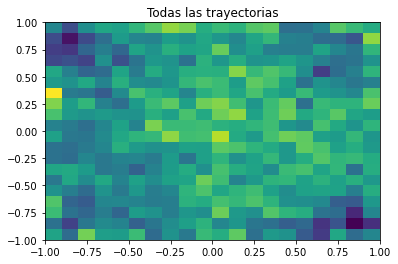

In [7]:
fig, ax = plt.subplots(1,1)
ax.hist2d(data_x, data_y, bins=20, range=[[limit_arena2, limit_arena], [limit_arena2, limit_arena]])
plt.title('Todas las trayectorias')
plt.show()
plt.pause(0.1)

In [8]:
hist, *edges = np.histogram2d(data_x, data_y, bins=20, range=[[limit_arena2, limit_arena], [limit_arena2, limit_arena]])
inx = np.digitize(data_x, edges[0], right=True)
iny = np.digitize(data_y, edges[1], right=True)

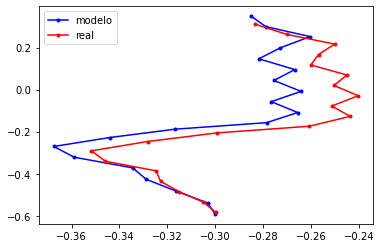

In [9]:
axisbins = list(zip(inx, iny))
axisbins = np.array(axisbins)

fig, ax = plt.subplots(1,1)
ax.plot(y2[-1,:,0].cpu().detach().numpy(), y2[-1,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax.plot(batch_y1[-1,:,0].cpu().detach().numpy(), batch_y1[-1,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()
plt.show()
plt.pause(0.1)

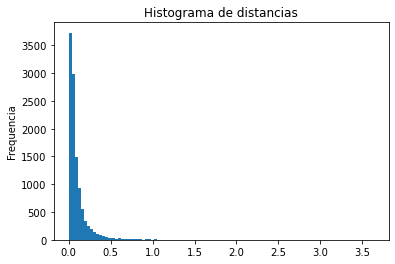

In [10]:
diferencia_array = np.zeros((2, y2[:,0,0].detach().numpy().size))

for i in range(y2[:,0,0].cpu().detach().numpy().size):
    x_dis, y_dis = distancia_modelo_real(y2[i, :, :].cpu().detach().numpy(), batch_y1[i, :, :].cpu().detach().numpy())
    diferencia_array[:,i] = [x_dis, y_dis]

plt.hist(diferencia_array[0,:], bins=100)
plt.gca().set(title='Histograma de distancias', ylabel='Frequencia')
plt.show()

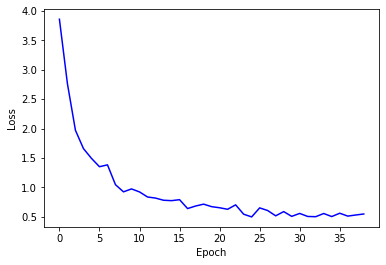

In [11]:
act_array = np.array(all_activation.cpu().detach().numpy())
act_array1 = np.reshape(act_array, [linear_size, 100], order = 'C')

final_array = np.zeros([20,20,100])
counter = np.zeros([20,20])
counter = np.expand_dims(counter, 2)

for n in range(linear_size):
    xbin = axisbins[n,0]
    ybin = axisbins[n,1]
    final_array[xbin-1,ybin-1,:] += act_array1[n,:]
    counter[xbin-1,ybin-1] += 1

plt.plot(all_losses[1:], c = 'b', label = 'total')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [12]:
all_activation_soft
act_array_soft = np.array(all_activation_soft.cpu().detach().numpy())
act_array2 = np.reshape(act_array_soft, [linear_size, 100], order = 'C')

final_array_soft = np.zeros([20,20,100])
counter = np.zeros([20,20])
counter = np.expand_dims(counter, 2)

for n in range(linear_size):
    xbin = axisbins[n,0]
    ybin = axisbins[n,1]
    final_array_soft[xbin-1,ybin-1,:] += act_array2[n,:]
    counter[xbin-1,ybin-1] += 1
print('done')

done


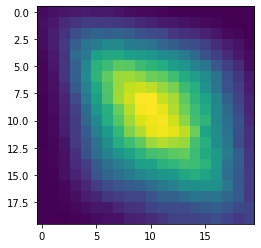

In [13]:
final_array = final_array / counter
final_array1 = final_array[:,:,0]
plt.imshow(final_array1)

Hidden layer


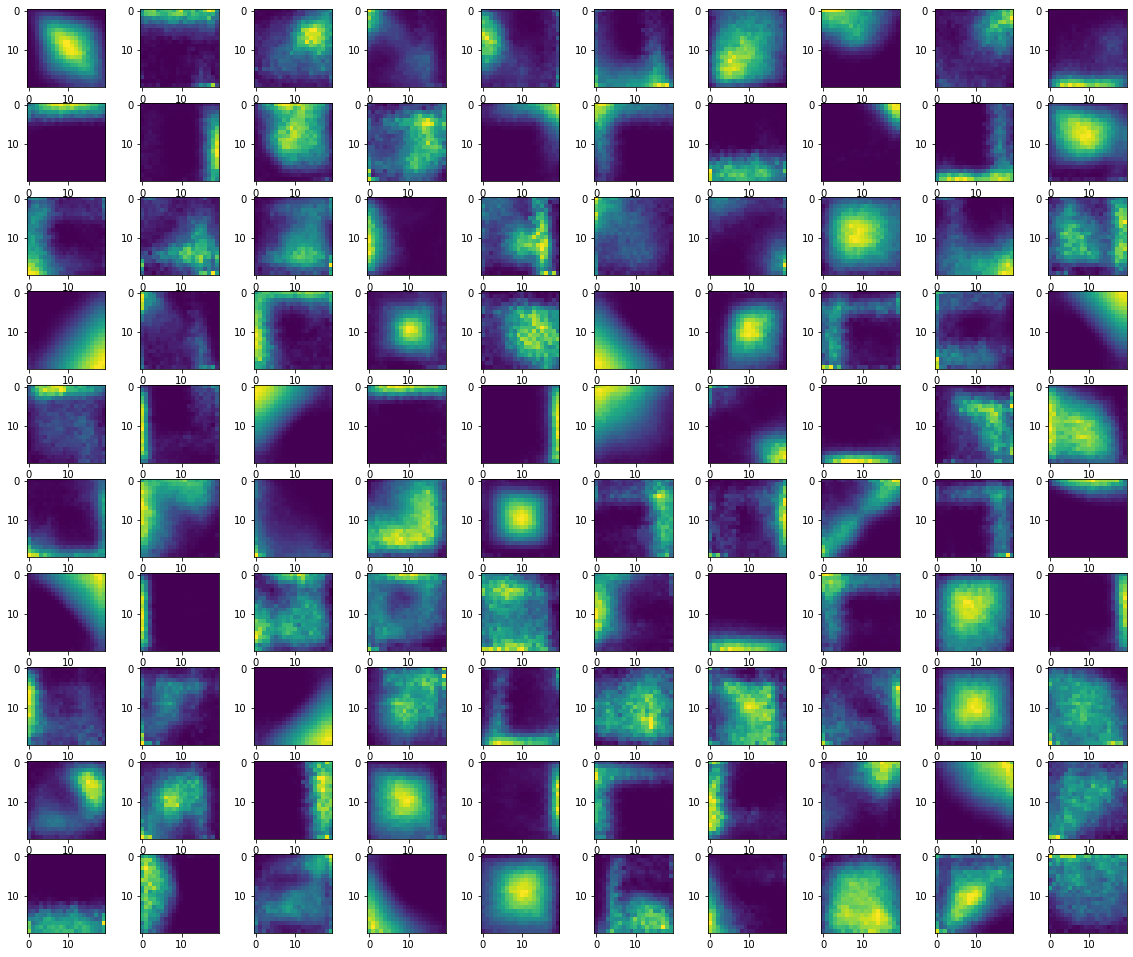

In [14]:
plt.figure(figsize=(20, 17))
for n in range(N_hidden_neurons):
    ax = plt.subplot(10, 10, n + 1)
    ax.imshow(final_array[:,:,n])
print('Hidden layer')

Softmax layer


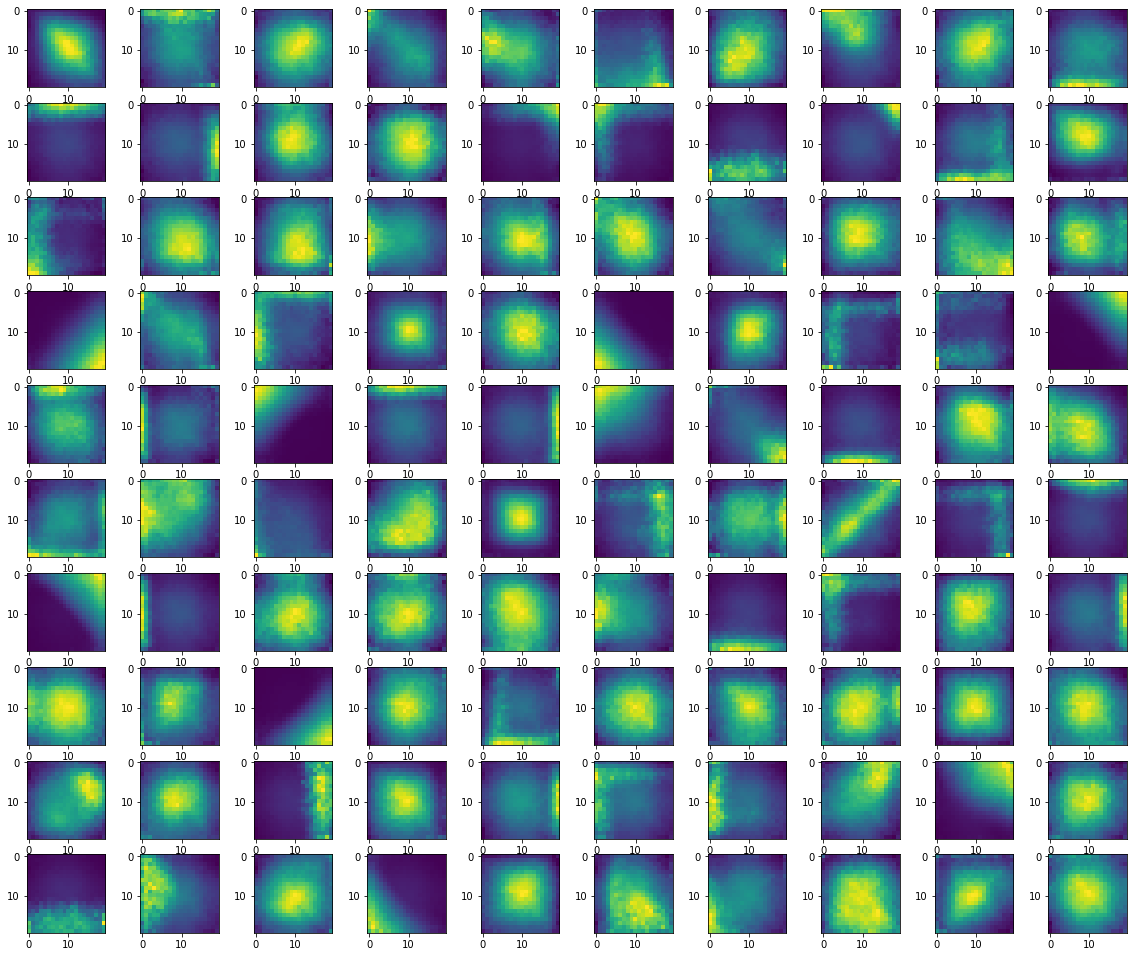

In [15]:
final_array_soft = final_array_soft / counter
final_array2 = final_array_soft[:,:,0]
plt.figure(figsize=(20, 17))
for n in range(N_hidden_neurons):
    ax = plt.subplot(10, 10, n + 1)
    ax.imshow(final_array_soft[:,:,n])
print('Softmax layer')

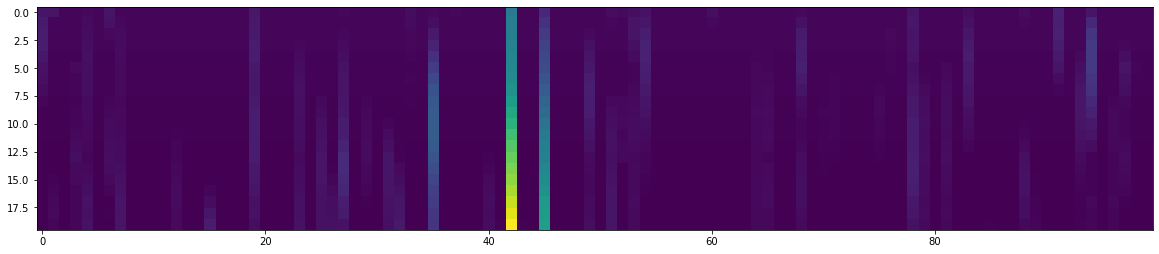

In [16]:
plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[0,:,:].cpu().detach().numpy())

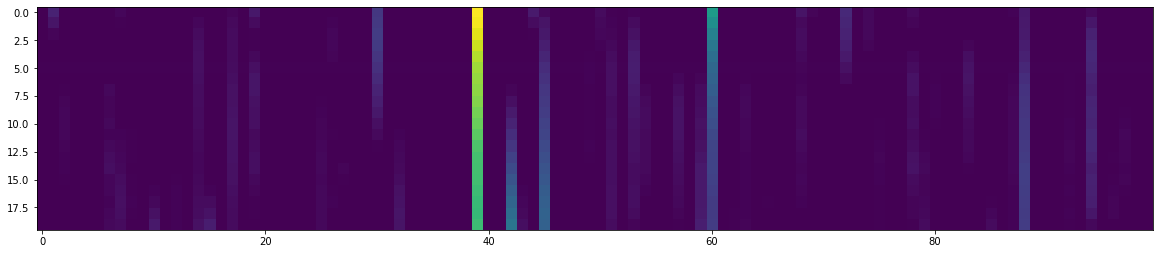

In [17]:
plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[1,:,:].cpu().detach().numpy())

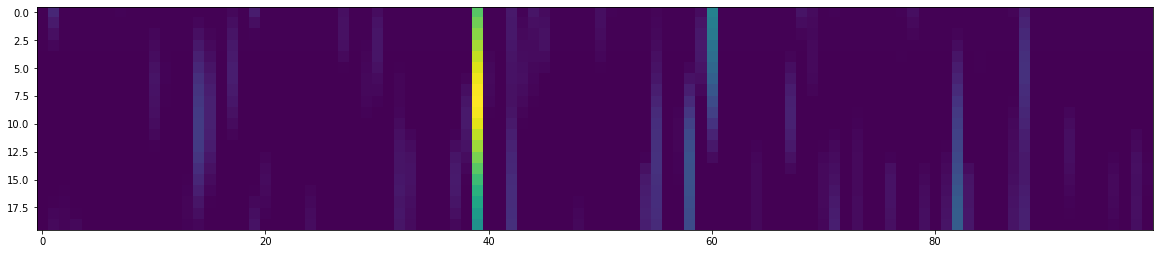

In [18]:
plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[5,:,:].cpu().detach().numpy())

In [19]:
all_activation_soft[5,:,69].cpu().detach().numpy()

array([0.0101217 , 0.01000331, 0.00998022, 0.01000496, 0.01002141,
       0.01000458, 0.00992584, 0.00976853, 0.00954222, 0.00948133,
       0.00948362, 0.00949078, 0.00949595, 0.00949521, 0.00948557,
       0.00948905, 0.0094962 , 0.00950541, 0.00951893, 0.00953908],
      dtype=float32)

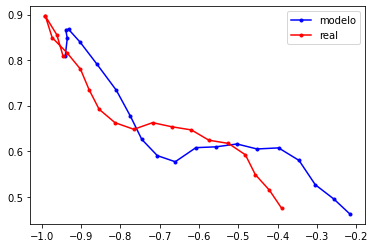

In [20]:
fig, ax = plt.subplots(1,1)
ax.plot(y2[5,:,0].cpu().detach().numpy(), y2[5,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax.plot(batch_y1[5,:,0].cpu().detach().numpy(), batch_y1[5,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()
plt.show()

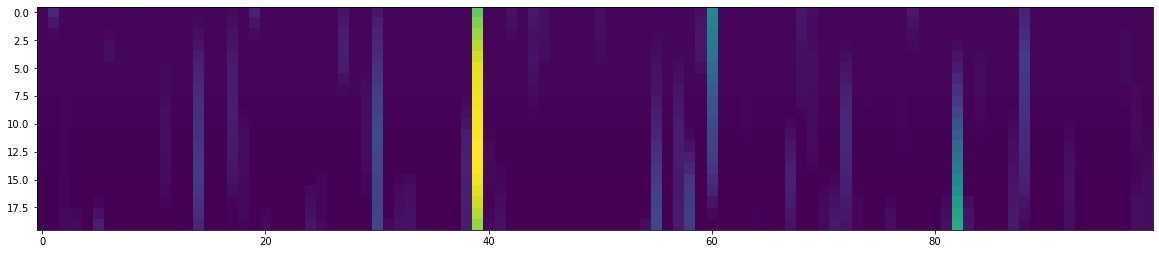

In [21]:
plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[10,:,:].cpu().detach().numpy())

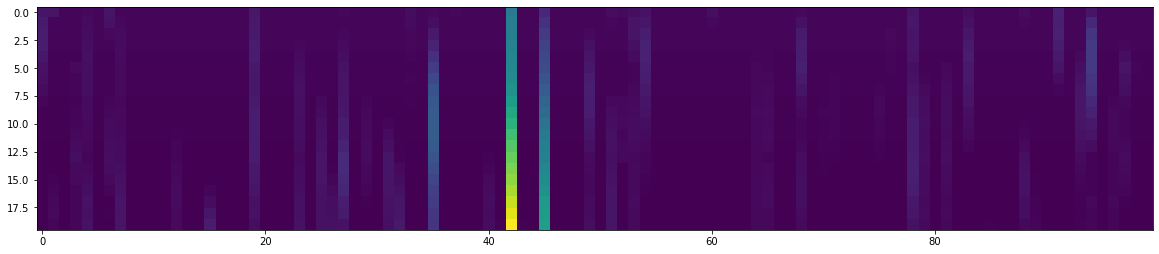

In [22]:
plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[0,:,:].cpu().detach().numpy())

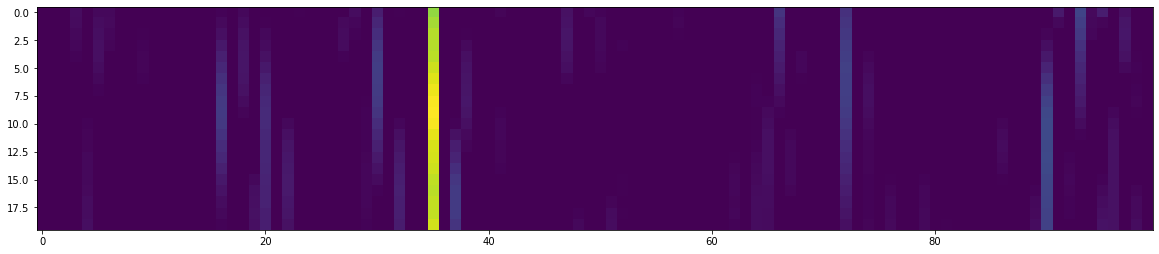

In [23]:
plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[15,:,:].cpu().detach().numpy())

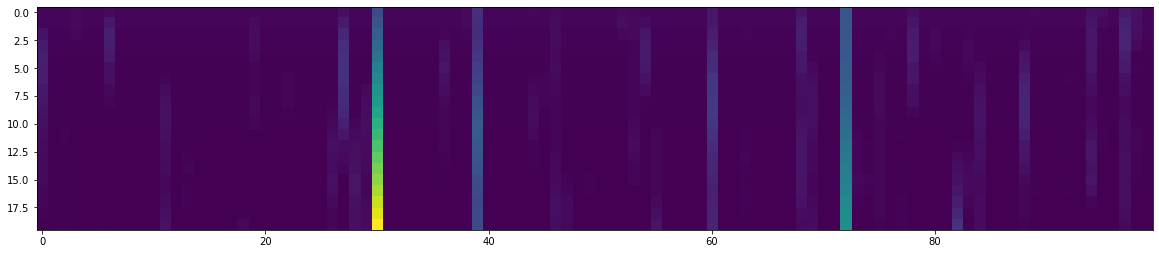

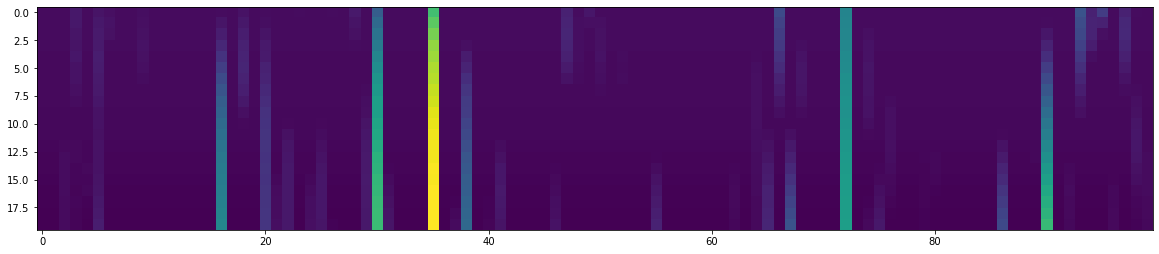

In [24]:
plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[20,:,:].cpu().detach().numpy())

plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[21,:,:].cpu().detach().numpy())

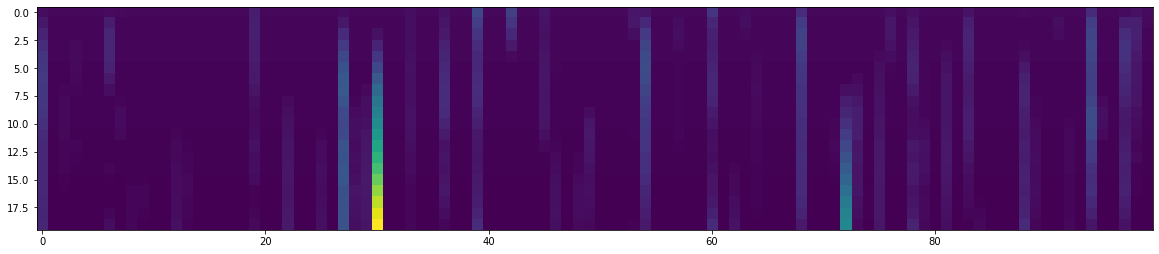

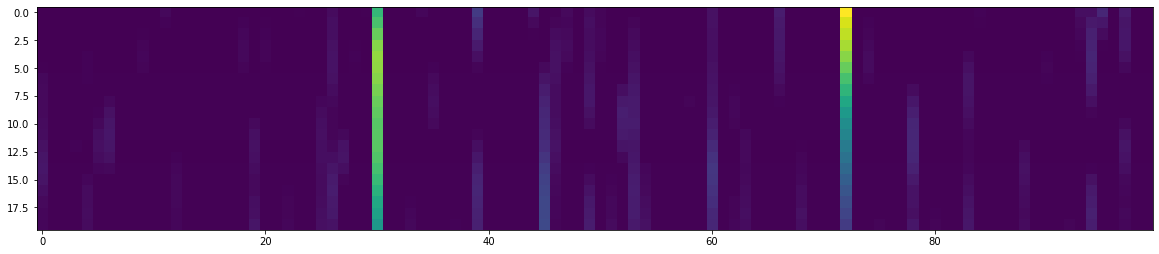

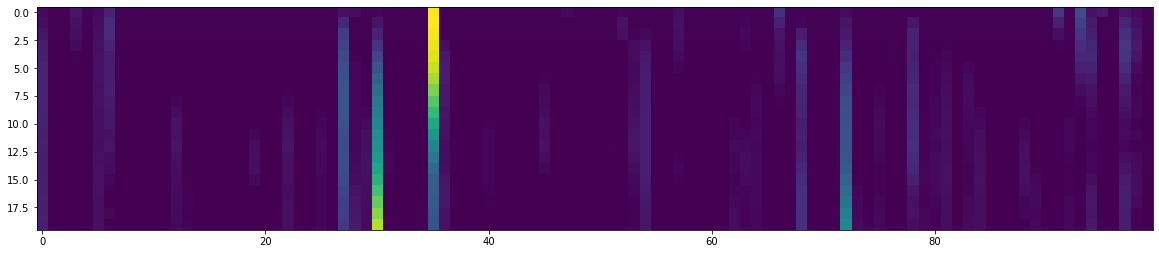

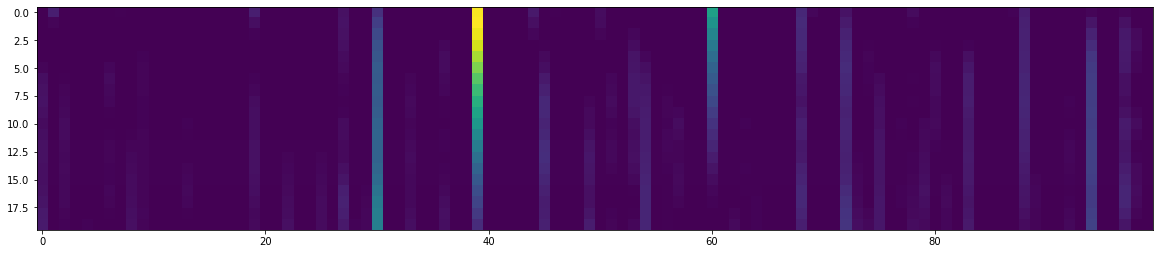

In [25]:
plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[22,:,:].cpu().detach().numpy())

plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[23,:,:].cpu().detach().numpy())

plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[24,:,:].cpu().detach().numpy())

plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[25,:,:].cpu().detach().numpy())

In [26]:
all_activation_soft[0,:,:].cpu().detach().numpy()

array([[0.01038214, 0.0103702 , 0.00986674, ..., 0.00986674, 0.00986674,
        0.00986674],
       [0.01063102, 0.0098444 , 0.0098444 , ..., 0.0098444 , 0.0098444 ,
        0.0098444 ],
       [0.01070329, 0.0098204 , 0.0098204 , ..., 0.0098204 , 0.0098204 ,
        0.0098204 ],
       ...,
       [0.00963789, 0.00992411, 0.00963789, ..., 0.00972125, 0.00963789,
        0.00963789],
       [0.00963386, 0.00995495, 0.00963386, ..., 0.00964354, 0.00963386,
        0.00963386],
       [0.00962741, 0.00989309, 0.00962741, ..., 0.00962741, 0.00962741,
        0.00962741]], dtype=float32)

In [27]:
all_activation_soft[0,0,:].cpu().detach().numpy()

array([0.01038214, 0.0103702 , 0.00986674, 0.00986674, 0.00990101,
       0.00986674, 0.01040923, 0.00987596, 0.00986674, 0.00986674,
       0.00986674, 0.00986674, 0.00986674, 0.00986674, 0.00986674,
       0.00986674, 0.00986674, 0.00986674, 0.00986674, 0.01053812,
       0.00986674, 0.00986674, 0.00986674, 0.00986674, 0.00986674,
       0.00986674, 0.00986674, 0.00990973, 0.00986674, 0.00986674,
       0.00986674, 0.00986674, 0.00986674, 0.01009472, 0.00986674,
       0.00992677, 0.00986674, 0.0099275 , 0.00986674, 0.00986674,
       0.00986674, 0.00986674, 0.01535621, 0.00986674, 0.00986674,
       0.01113876, 0.00986674, 0.00986674, 0.00986674, 0.00986674,
       0.00986674, 0.01006119, 0.00997515, 0.01013771, 0.01029523,
       0.00986674, 0.00986674, 0.00986674, 0.00986674, 0.00986674,
       0.01013493, 0.00986674, 0.00986857, 0.00986674, 0.00986674,
       0.00986674, 0.00986674, 0.00986674, 0.00994885, 0.00986674,
       0.00986674, 0.00986674, 0.00986674, 0.00986674, 0.00986

In [28]:
all_activation_soft[0,4,:].cpu().detach().numpy().max()

0.01595469

In [29]:
my_network4 = torch.load('/kaggle/working/MyNetworkKaggle3.tar')
my_network4.linear3.weight

Parameter containing:
tensor([[-1.4242,  1.1416, -1.1406, -0.6121, -0.5725,  1.9941,  1.0825,  0.6118,
          1.1593, -0.0802, -1.6236,  0.9689, -0.4135,  0.6740, -0.5796, -0.9262,
          1.1384,  1.0092,  1.2319, -1.1535, -0.4924, -1.1246,  0.1628, -0.4092,
          0.2343,  0.2892, -0.0558,  1.1393,  0.2314, -1.4061,  0.1551, -0.1351,
          0.0379,  0.2325, -1.1702, -0.5942, -0.6339, -0.9955,  0.3193, -0.1283,
         -0.1950, -1.3119,  0.3009,  0.5920,  0.2974,  0.1422,  0.7503, -0.4023,
          1.6461,  1.3772],
        [ 0.8487,  1.1298,  1.0967,  0.1516, -0.4463, -0.7876,  0.3029, -0.1316,
          0.0229,  1.6402, -0.3084, -0.3589, -0.5943,  0.5079, -0.5066,  0.2273,
          1.1090,  0.3619, -0.6491, -0.6248,  0.1572, -1.2825, -0.4386, -0.8775,
         -0.9644, -0.4938,  1.0593, -1.5866, -1.5059,  1.5060,  0.5822, -1.0094,
          0.2602,  1.0714,  1.0948,  0.4462,  0.0611, -0.1425,  0.2793,  0.1290,
         -1.2961, -1.5801,  0.9729, -0.5142, -0.9910,  0.82